# Sheep Breed Classification using EfficientNetB3

This Google Colab notebook demonstrates a deep learning approach for classifying different breeds of sheep using transfer learning with the EfficientNetB3 architecture.

## Project Goal

The primary objective of this project is to build and train an image classification model capable of accurately identifying various sheep breeds from images. This can be useful for automated livestock management, breed research, and agricultural applications.

## Model Architecture

The model leverages **EfficientNetB3**, a highly efficient and accurate convolutional neural network, as its backbone for feature extraction. We employ a transfer learning strategy:

*   **Base Model:** EfficientNetB3, pre-trained on the ImageNet dataset, is used without its original top classification layer.
*   **Custom Head:** A custom classification head is added on top of the EfficientNetB3 base. This head consists of:
    *   `GlobalAveragePooling2D`: Reduces spatial dimensions.
    *   `BatchNormalization`: Stabilizes training.
    *   `Dropout` layers (with rates 0.4 and 0.3): Prevents overfitting.
    *   Two `Dense` layers: A hidden layer with 512 units and ReLU activation, and a final output layer with `num_classes` units and `softmax` activation for multi-class classification.

## Training Strategy

The training is conducted in two distinct phases to optimize performance and prevent catastrophic forgetting:

1.  **Phase A: Head Training (Frozen Base)**
    *   The weights of the EfficientNetB3 base model are initially **frozen** (set to `trainable=False`).
    *   Only the custom classification head's layers are trained for a few epochs (`EPOCHS_HEAD`). This allows the newly added layers to learn to interpret the high-level features extracted by the pre-trained EfficientNetB3.

2.  **Phase B: Fine-tuning (Unfrozen Base)**
    *   After Phase A, a portion of the EfficientNetB3 base model (specifically, the top 40 layers) is **unfrozen** (set to `trainable=True`).
    *   The entire model (frozen lower layers of EfficientNetB3, unfrozen top layers of EfficientNetB3, and the custom head) is then fine-tuned with a significantly lower learning rate (`1e-5` vs `1e-4` in Phase A) for more epochs (`EPOCHS_FINE`). This step allows the model to adapt the pre-trained features more specifically to the sheep breed dataset.

## Dataset

The model is trained on a dataset of sheep images, structured into directories representing different breeds. The notebook assumes the data is organized with subdirectories for `train` and `val` (validation) containing breed-specific folders. The identified classes are:

*   `Marino`
*   `Poll Dorset`
*   `Suffolk`
*   `White Suffolk`

## Data Augmentation

To improve the model's generalization capabilities and robustness, on-the-fly data augmentation is applied during training. This includes:

*   `RandomFlip("horizontal")`
*   `RandomRotation(0.15)`
*   `RandomZoom(0.1)`
*   `RandomTranslation(0.05, 0.05)`

## Training Configuration

*   **Image Size:** `300x300` pixels (`IMG_SIZE`).
*   **Batch Size:** `32` (`BATCH_SIZE`).
*   **Optimizer:** Adam optimizer.
*   **Loss Function:** `sparse_categorical_crossentropy` (suitable for integer labels).
*   **Metrics:** `accuracy`.
*   **Callbacks:**
    *   `ReduceLROnPlateau`: Reduces the learning rate when the validation loss plateaus.
    *   `EarlyStopping`: Stops training if the validation loss does not improve for a specified number of epochs, restoring the best model weights.
*   **Class Weights:** Applied to address potential class imbalance in the dataset.

## Usage

To run this notebook and train your own sheep breed classifier:

1.  **Open in Google Colab:** Upload and open this notebook in Google Colab.
2.  **Mount Google Drive:** Ensure your Google Drive is mounted. The notebook will attempt to do this automatically. Your dataset should be located at `/content/drive/MyDrive/sheep` (or adjust the `DATA_PATH` variable in the code).
    *   The `sheep` directory should directly contain subdirectories for each breed (e.g., `sheep/Marino`, `sheep/Poll Dorset`, etc.).
3.  **Run Cells Sequentially:** Execute all code cells in order.

## Current Status

*   **Dataset Preparation:** The notebook correctly identifies 4 classes: `['Marino', 'Poll Dorset', 'Suffolk', 'White Suffolk']`.
*   **Phase A Training (Head Training):** Successfully completed for 8 epochs. The model learns initial weights for the custom classification head while the EfficientNetB3 base is frozen.
*   **Phase B Training (Fine-tuning):** The model is recompiled, and the top 40 layers of EfficientNetB3 are unfrozen for fine-tuning, allowing the entire model to adapt further to the specific task.
*   **Evaluation:** The notebook includes cells for evaluating the model's performance on the validation set, including a classification report and confusion matrix.
*   **Test-Time Augmentation (TTA):** A function `tta_predict` is implemented to demonstrate how Test-Time Augmentation can be used to potentially boost prediction accuracy by averaging predictions from augmented versions of a single image.
*   **Model Saving:** The final trained model is saved in the `.keras` format to your Google Drive.

## Potential Improvements and Future Work

*   **Hyperparameter Tuning:** Experiment with different learning rates, dropout values, and the number of unfrozen layers during fine-tuning.
*   **Advanced Data Augmentation:** Explore more sophisticated augmentation techniques.
*   **Cross-Validation:** Implement k-fold cross-validation for a more robust evaluation of model performance.
*   **Deployment:** Convert the model to TensorFlow Lite for deployment on mobile or edge devices.
*   **User Interface:** Implement a more comprehensive Gradio interface or a web application for easier interaction and real-time inference.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/sheep'

!ls "$data_path"

 Marino  'Poll Dorset'	 Suffolk  'White Suffolk'


In [ ]:
import os
import cv2

folder = '/content/drive/MyDrive/sheep'
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    img = cv2.imread(img_path)
    # do something with img


In [ ]:
# Check GPU
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Path to your dataset (already mounted)
DATA_PATH = '/content/drive/MyDrive/sheep'
!ls -la "$DATA_PATH"


TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
total 16
drwx------ 2 root root 4096 Oct 11 12:45  Marino
drwx------ 2 root root 4096 Oct 11 12:45 'Poll Dorset'
drwx------ 2 root root 4096 Oct 11 12:45  Suffolk
drwx------ 2 root root 4096 Oct 11 12:45 'White Suffolk'


In [ ]:
# //1 — Prepare datasets (train/val/test)
import pathlib
import os
import tensorflow as tf

DATA_PATH = '/content/drive/MyDrive/sheep'
data_dir = pathlib.Path(DATA_PATH)

IMG_SIZE = 300            # EfficientNetB3 recommended ~300
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names, "Num classes:", num_classes)


Found 1158 files belonging to 4 classes.
Using 927 files for training.
Found 1158 files belonging to 4 classes.
Using 231 files for validation.
Classes: ['Marino', 'Poll Dorset', 'Suffolk', 'White Suffolk'] Num classes: 4


In [ ]:
# Performance: cache & prefetch
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# 3 — Data augmentation (on-the-fly)from tensorflow.keras import layers

import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
], name="data_augmentation")

data_augmentation.summary()



Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_2            │ ?                      │   0 (unbuilt) │
│ (RandomTranslation)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4 — Build model with EfficientNetB3 (transfer learning)
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as apps

INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = apps.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=INPUT_SHAPE,
    pooling=None
)
base_model.trainable = False   # freeze for Phase A

inputs = Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)                 # augmentation only during training
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs, name="EffNetB3_sheep")

# Recompile the model with the original settings
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "EffNetB3_sheep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,578,675 (44.17 MB)

 Trainable params: 792,068 (3.02 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
# 5 — Callbacks (checkpoint, LR schedule, early stop)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint_path = '/content/drive/MyDrive/sheep_effnetb3_best.h5'
callbacks = [
    # ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]

In [ ]:
# Fast class count (batch-wise) — much faster than unbatch()
import numpy as np
from collections import Counter
import time

start = time.time()

# initialize counts
counts = np.zeros(num_classes, dtype=np.int64)

# train_ds yields batches of (images, labels)
for _, y_batch in train_ds:            # iterate per batch (not per example)
    y_np = y_batch.numpy()             # shape (batch_size,)
    counts += np.bincount(y_np, minlength=num_classes)

total = int(counts.sum())
class_counts = {i: int(counts[i]) for i in range(num_classes)}
class_counts, "total:", total, "time(s):", round(time.time() - start, 3)


({0: 137, 1: 302, 2: 180, 3: 308}, 'total:', 927, 'time(s):', 270.384)

In [ ]:
class_weights = {i: total / (num_classes * max(1, class_counts[i])) for i in range(num_classes)}
print("Class counts:", class_counts)
print("Class weights:", class_weights)


Class counts: {0: 137, 1: 302, 2: 180, 3: 308}
Class weights: {0: 1.6916058394160585, 1: 0.7673841059602649, 2: 1.2875, 3: 0.752435064935065}


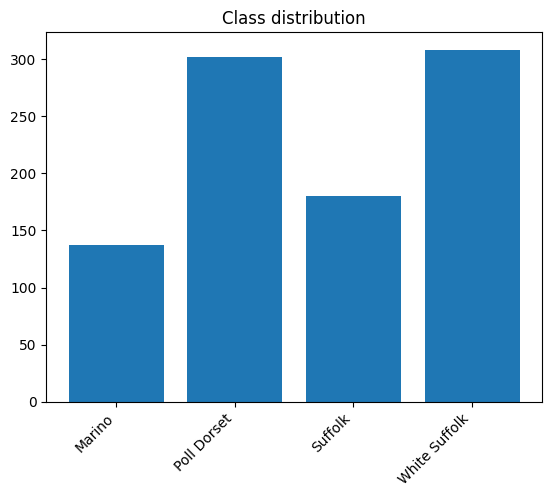

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(num_classes), counts)
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.title('Class distribution')
plt.show()


In [ ]:
# 7 — Phase A: train head (frozen base)
EPOCHS_HEAD = 8
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
    class_weight=class_weights   # uncomment if used
)

Epoch 1/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 299ms/step - accuracy: 0.7416 - loss: 0.7156 - val_accuracy: 0.9004 - val_loss: 0.3739 - learning_rate: 1.0000e-05
Epoch 2/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.7115 - loss: 0.7090 - val_accuracy: 0.9004 - val_loss: 0.3738 - learning_rate: 1.0000e-05
Epoch 3/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.7277 - loss: 0.7066 - val_accuracy: 0.8961 - val_loss: 0.3732 - learning_rate: 1.0000e-05
Epoch 4/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.7036 - loss: 0.7760 - val_accuracy: 0.9004 - val_loss: 0.3703 - learning_rate: 1.0000e-05
Epoch 5/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.7453 - loss: 0.6990 - val_accuracy: 0.8961 - val_loss: 0.3693 - learning_rate: 1.0000e-05
Epoch 6/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.6816 - loss: 0.7304 - val_accuracy: 0.8918 - val_loss: 0.3693 - learning_rate: 1.0000e-05
Epoch 7/8
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.6975

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
               precision    recall  f1-score   support

       Marino       0.69      0.80      0.74        25
  Poll Dorset       0.86      0.89      0.88        72
      Suffolk       0.98      0.98      0.98        46
White Suffolk       0.96      0.90      0.93        88

     accuracy                           0.90       231
    macro avg       0.87      0.89      0.88       231
 weighted avg       0.91      0.90

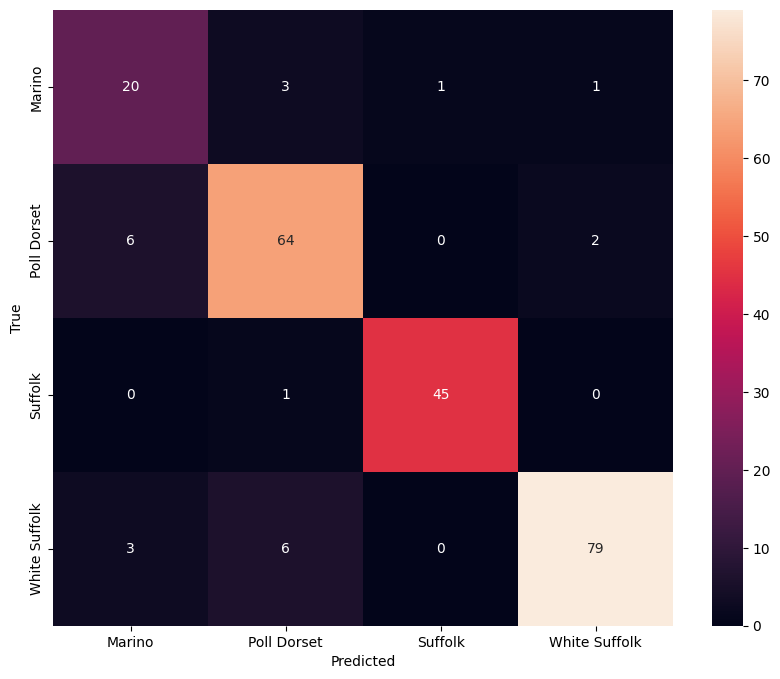

In [ ]:
# 9 — Evaluate & confusion matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# load best weights (checkpoint already does that but safe)
# model.load_weights(checkpoint_path)

# prepare arrays of predictions and labels from val set
y_true = []
y_pred = []

for x, y in val_ds.unbatch().batch(BATCH_SIZE):
    preds = model.predict(x)
    y_true.extend(y.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

In [ ]:
# 10 — Test-time augmentation (TTA) & ensembling (boost accuracy)
import tensorflow as tf
def tta_predict(model, img_tensor, tta_steps=8):
    preds = []
    for _ in range(tta_steps):
        aug = data_augmentation(img_tensor, training=True)
        p = model(aug, training=False)
        preds.append(p.numpy())
    return np.mean(preds, axis=0)

# Example: run TTA on first batch of val_ds
for x, y in val_ds.take(1):
    preds = [tta_predict(model, tf.expand_dims(x[i],0), tta_steps=8) for i in range(len(x))]
    preds = np.vstack(preds)
    print("TTA preds shape:", preds.shape)
    break



TTA preds shape: (32, 4)


In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc*100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.9122 - loss: 0.3123
Validation Accuracy: 90.04%
Validation Loss: 0.3576


In [7]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# Define variables from your notebook
IMG_SIZE = 300
DATA_PATH = '/content/drive/MyDrive/sheep'
final_model_path = '/content/drive/MyDrive/sheep_effnetb3_final.keras'

# --- Load Class Names ---
# This part assumes your DATA_PATH directly contains the class subfolders
# (e.g., /content/drive/MyDrive/sheep/Marino, /content/drive/MyDrive/sheep/Poll Dorset, etc.)
# If your data is in train/val subdirectories, you might need to adjust this
# to point to one of those or list them manually.

# Option 1: Derive class names from data_path (assuming it's the root of class folders)
# (This is less robust if DATA_PATH is not the parent of class folders directly)
# class_names = sorted([d.name for d in os.scandir(DATA_PATH) if d.is_dir()])

# Option 2: Manually define class names (most reliable if you know them)
class_names = ['Marino', 'Poll Dorset', 'Suffolk', 'White Suffolk'] # Based on your notebook's output

if not os.path.exists(final_model_path):
    raise FileNotFoundError(f"Model not found at {final_model_path}. Please ensure the model was saved correctly.")

# Load the trained model
print(f"Loading model from: {final_model_path}")
model = tf.keras.models.load_model(final_model_path)
print("Model loaded successfully.")

# Define the prediction function for Gradio
def predict_image(image: Image.Image):
    if image is None:
        return {class_name: 0.0 for class_name in class_names}

    # Resize and preprocess the image
    image = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    # EfficientNet preprocessing
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)[0]

    # Return a dictionary of class names and their probabilities
    return {class_names[i]: float(predictions[i]) for i in range(len(class_names))}

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Sheep Image"),
    outputs=gr.Label(num_top_classes=len(class_names)),
    title="Sheep Breed Classifier",
    description="Upload an image of a sheep to classify its breed using an EfficientNetB3 model.",
    examples=[
        # Add example image paths here if you have them
        # e.g., "/content/drive/MyDrive/sheep/Marino/example_marino.jpg"
    ]
)

# Launch the Gradio interface
print("Launching Gradio interface...")
# Changed debug=True to debug=False for potential performance improvement
iface.launch(debug=False, share=True)


Loading model from: /content/drive/MyDrive/sheep_effnetb3_final.keras
Model loaded successfully.
Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://33039762c51f9a09c9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://33039762c51f9a09c9.gradio.live
